### Load Dataset

In [1]:
import pandas as pd
data = pd.read_csv("/kaggle/input/flight-price-prediction/Clean_Dataset.csv")
data.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


### Data Exploration

In [2]:
data.airline.value_counts()

airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: count, dtype: int64

In [3]:
data.source_city.value_counts()

source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: count, dtype: int64

In [4]:
data.departure_time.value_counts()

departure_time
Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: count, dtype: int64

In [5]:
data.stops.value_counts()

stops
one            250863
zero            36004
two_or_more     13286
Name: count, dtype: int64

In [6]:
data.arrival_time.value_counts()

arrival_time
Night            91538
Evening          78323
Morning          62735
Afternoon        38139
Early_Morning    15417
Late_Night       14001
Name: count, dtype: int64

In [7]:
data.destination_city.value_counts()

destination_city
Mumbai       59097
Delhi        57360
Bangalore    51068
Kolkata      49534
Hyderabad    42726
Chennai      40368
Name: count, dtype: int64

In [8]:
data['class'].value_counts()

class
Economy     206666
Business     93487
Name: count, dtype: int64

### Data Preprocessing

In [9]:
# Drop irrelevant features
data = data.drop('Unnamed: 0', axis=1)
data = data.drop('flight', axis=1)

# Convert categorical variables to numerical
# Binary Encoding
data['class'] = data['class'].apply(lambda x : 1 if x == 'Business' else 0)

# Factorize categorical column
data.stops = pd.factorize(data.stops)[0]

# One-Hot Encoding
data = data.join(pd.get_dummies(data.airline, prefix='airline')).drop('airline', axis=1)
data = data.join(pd.get_dummies(data.source_city, prefix='source')).drop('source_city', axis=1)
data = data.join(pd.get_dummies(data.departure_time, prefix='departure')).drop('departure_time', axis=1)
data = data.join(pd.get_dummies(data.arrival_time, prefix='arrival')).drop('arrival_time', axis=1)
data = data.join(pd.get_dummies(data.destination_city, prefix='dest')).drop('destination_city', axis=1)

data.head()

,stops,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,...,arrival_Evening,arrival_Late_Night,arrival_Morning,arrival_Night,dest_Bangalore,dest_Chennai,dest_Delhi,dest_Hyderabad,dest_Kolkata,dest_Mumbai
0,0,0,2.17,1,5953,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
1,0,0,2.33,1,5953,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0,0,2.17,1,5956,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,0,0,2.25,1,5955,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,0,0,2.33,1,5955,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True


### Train Regression Model

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

x, y = data.drop('price', axis=1), data.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

reg = RandomForestRegressor(n_jobs=-1)
reg.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1)

### Model Evaluation

In [11]:
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = reg.predict(x_test)

print(f"R2 = {r2_score(y_test, y_pred)}")
print(f"MAE = {mean_absolute_error(y_test, y_pred)}")
print(f"MSE = {mean_squared_error(y_test, y_pred)}")
print(f"RMSE = {sqrt(mean_squared_error(y_test, y_pred))}")

R2 = 0.9852313655914972
MAE = 1080.0127912893154
MSE = 7667384.398128299
RMSE = 2769.004225010915


Text(0.5, 1.0, 'Prediction VS Actual Flight Price')

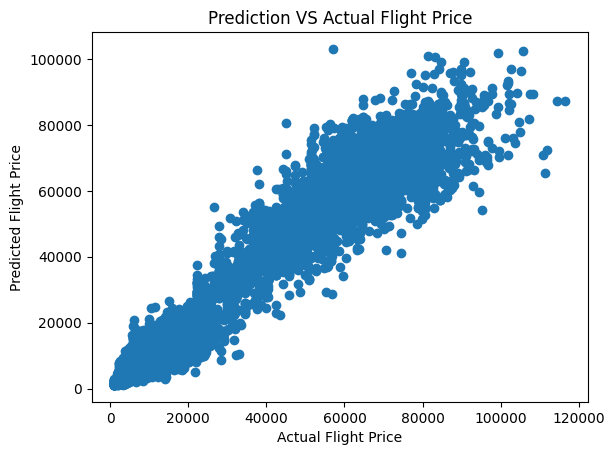

In [12]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Flight Price')
plt.ylabel('Predicted Flight Price')
plt.title('Prediction VS Actual Flight Price')

<BarContainer object of 10 artists>

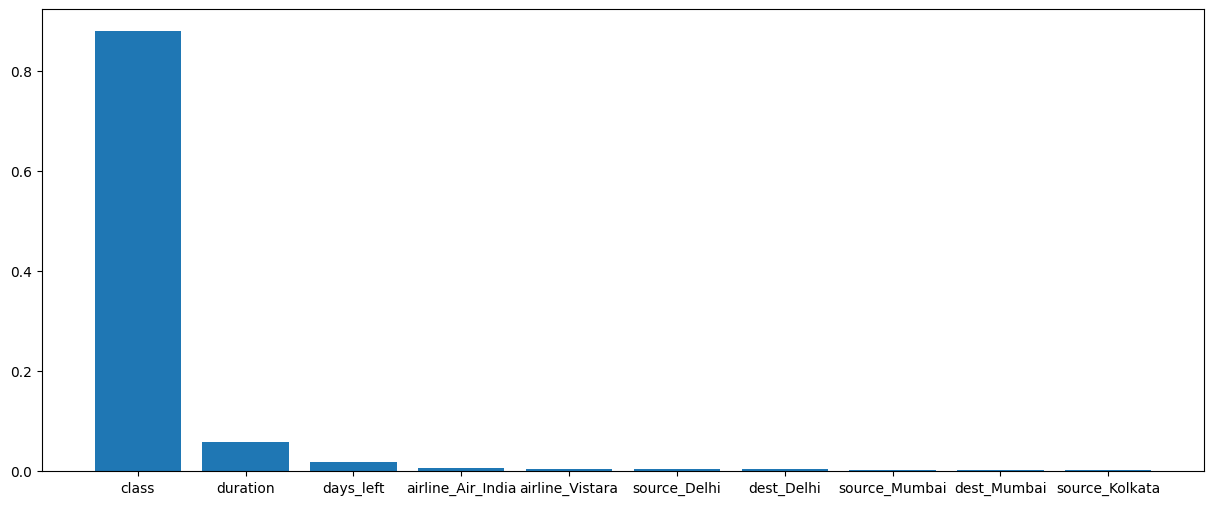

In [13]:
# Get the most important features
importances = dict(zip(reg.feature_names_in_, reg.feature_importances_))
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(15,6))
plt.bar([x[0] for x in sorted_importances[:10]], [x[1] for x in sorted_importances[:10]])

### Hyperparameter Tuning

In [14]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['log2', 'sqrt']
}

# Initialize the RandomForestRegressor
best_reg = RandomForestRegressor(n_jobs=-1)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=best_reg, param_grid=param_grid, cv=5, n_jobs=-1, verbose=True)

# Fit the grid search
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_params

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 300}

In [15]:
best_reg = RandomForestRegressor(**best_params, n_jobs=-1)
best_reg.fit(x_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_split=5,
                      n_estimators=300, n_jobs=-1)

In [16]:
y_pred = best_reg.predict(x_test)

print(f"R2 = {r2_score(y_test, y_pred)}")
print(f"MAE = {mean_absolute_error(y_test, y_pred)}")
print(f"MSE = {mean_squared_error(y_test, y_pred)}")
print(f"RMSE = {sqrt(mean_squared_error(y_test, y_pred))}")

R2 = 0.9851206848005936
MAE = 1245.7397378793498
MSE = 7724846.1881539365
RMSE = 2779.360751711432
